<a href="https://colab.research.google.com/github/Gautam-Chauhan/Gautam-Chauhan/blob/main/cw1_02200568.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
## Summative assessment
### Coursework 1

#### Instructions

This coursework is released on **12th February 9.00 (UK time)** and is due by **26th February 9.00 (UK time)**. It is worth **50%** of your overall mark. There are 4 questions in this assessment, and a total of 50 marks are available. **You should attempt to answer all questions.** In addition to the total number of marks shown per question below, an additional 5 marks is available for presentation and clarity/quality of code.

This assessment assesses your ability to design, implement, train and evaluate a deep learning model for a recommender system. This is the problem of recommending suitable items to a given user.

You can make imports as and when you need them throughout the notebook, and add code cells where necessary. Make sure your notebook executes correctly in sequence before submitting. You should use Keras for this assessment, only reverting to backend-specific implementations where necessary.

The data required for this assessment can also be downloaded from [this link](https://drive.google.com/file/d/1Px16gtpLczdnpTmewBSnhKL_cIAY22w7/view?usp=sharing) in case you would prefer to work locally.

#### Submission instructions

The submission for this assessment will consist of a notebook (.ipynb file) and PDF report.

Ensure your notebook executes correctly in order. Save your notebook .ipynb file **after you have executed it** (so that outputs are all showing). It is recommended to also submit a PDF/HTML copy of your executed notebook, in case the .ipynb file is corrupted for some reason.

Upload a zip file containing your notebook and separate PDF/HTML file(s) by the deadline above.

This assignment must be attempted individually; your submission must be your own, unaided work. Candidates are prohibited from discussing assessed coursework, and must abide by [Imperial College’s rules](https://www.imperial.ac.uk/media/imperial-college/administration-and-support-services/registry/academic-governance/public/academic-policy/academic-integrity/Examination-and-assessments---academic-integrity.pdf) regarding academic integrity and plagiarism. Unless specifically authorised within the assignment instructions, the submission of output from [generative AI tools](https://www.imperial.ac.uk/about/leadership-and-strategy/provost/vice-provost-education/generative-ai-tools-guidance/) (e.g., ChatGPT) for assessed coursework is prohibited. Violations will be treated as an examination offence. Enabling other candidates to plagiarise your work constitutes an examination offence. To ensure quality assurance is maintained, departments may choose to invite a random selection of students to an ‘authenticity interview’ on their submitted assessments.

In [1]:
# You will need the following imports for this assessment. You can make additional imports when you need them

import keras
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from keras.models import Sequential, Model
import torch


In [2]:
# Mount google drive (as this was done using Google Colab)
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#### YOOCHOOSE Dataset

This assessment makes use of the YOOCHOOSE dataset, which contains a collection of sessions from a retailer, where each session
consists of the item click events that a user performed in the session. The dataset is a standard benchmark dataset for the development of session-based recommendation algorithms. Session-based recommendation is where user IDs are not available, but sessions containing data about how users interact with a platform are available. The YOOCHOOSE dataset was created by YOOCHOOSE GmbH for the [2015 Recsys Challenge](https://recsys.acm.org/recsys15/challenge/).

The full dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/chadgostopp/recsys-challenge-2015). It contains the data files `yoochoose-clicks.dat`, `yoochoose-test.dat` and `yoochoose-buys.dat`, as well as a `dataset-README.txt` file that describes the dataset. For this assessment only the data in `yoochoose-clicks.dat` will be used, and for this coursework a subset `yoochoose-clicks-subset.dat` has been prepared for you and is made available in the `./data` folder, as well as on Blackboard.

#### Recommender systems

Your task in this assessment is to develop a deep learning model that can be used to predict the next item that a user will interact with during a session of item click events. The model will take the sequence of items clicked on so far as the input, and will output a set of logits (that can be converted to probabilities using the softmax function) across the set of possible items.

In question 1 you will explore the dataset and prepare it for training your model. The training algorithm and model will be custom written for this task. In particular, the model will implement a particular form of weight sharing, and the training algorithm will employ custom logic that uses the specific training examples in a batch in order to reduce the computational load. In question 2 you will train and evaluate the specified model.

The model design and training algorithm will potentially require several hyperparameter choices, and in question 3 you should experiment with different choices during the development of your model, using a base model as a benchmark. It is up to you which experiments you will run. It is not necessary to include all experiments carried out in code in this notebook. You only need to include any custom code that you have written, and the code for the final choice of hyperparameters (in order to avoid overly long notebook submissions). In question 4 you will write a report detailing the experiments carried out.

### Question 1 (Total 10 marks)

a) In this question, you should load the `yoochoose-clicks-subset.dat` data into a pandas DataFrame, and carry out a basic exploration and analysis of the dataset. Compute, display and visualise any properties you deem to be relevant, along with some basic information on the click events, sessions and items. You can also use comments and/or markdown as appropriate.

The 'Category' column will not be used in this assessment, so can be ignored.

**(2 marks)**

In [3]:
df = pd.read_csv("/content/drive/MyDrive/deep_learning_cw1/yoochoose-clicks-subset.dat",header=None,names=["Session ID","Timestamp","Item ID","Category"])

/tmp/ipython-input-2655839245.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/deep_learning_cw1/yoochoose-clicks-subset.dat",header=None,names=["Session ID","Timestamp","Item ID","Category"])


In [4]:
# Drop the Category Column
df.drop(["Category"],axis=1,inplace=True)
# Convert the times to datetime objects
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

In [5]:
# Visualise the first 10 rows of the dataset
df.head(10)

,Session ID,Timestamp,Item ID
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,3,2014-04-02 13:17:46.940000+00:00,214716935
5,3,2014-04-02 13:26:02.515000+00:00,214774687
6,3,2014-04-02 13:30:12.318000+00:00,214832672
7,4,2014-04-07 12:09:10.948000+00:00,214836765
8,4,2014-04-07 12:26:25.416000+00:00,214706482
9,7,2014-04-02 06:38:53.104000+00:00,214826835


Basic summary of data, including minimum, maximum and count of each variable:

In [6]:
session_ids = df["Session ID"].unique()
item_ids = df["Item ID"].unique()
times = df["Timestamp"]

session_id_summary = [min(session_ids),max(session_ids),len(session_ids)]
item_id_summary = [min(item_ids),max(item_ids),len(item_ids)]
times_summary = [times.min(),times.max(),times.count()]

summary_df = pd.DataFrame([session_id_summary,item_id_summary,times_summary],columns=["Min","Max","Count"])
summary_df.index = ["Session ID","Item ID","Times"]
summary_df.head(3)

,Min,Max,Count
Session ID,1,11562161,6012324
Item ID,214507224,1178837797,49499
Times,2014-04-01 03:00:00.124000+00:00,2014-09-30 02:59:59.430000+00:00,21452447


Show the distribution of session lengths using a histogram (red line is where there are more than 10 clicks per session, and we discard the data above this line)

Text(0, 0.5, 'Number of sessions')

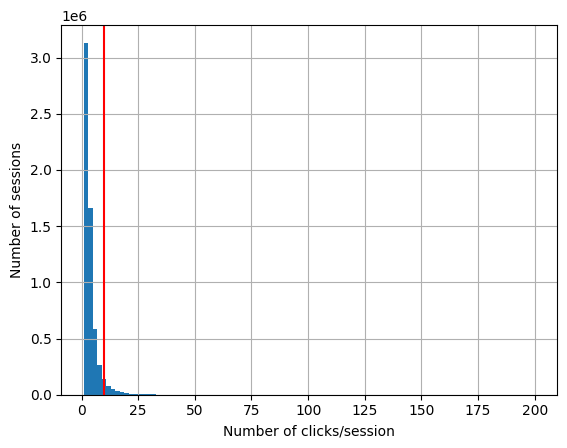

In [9]:
df["Session ID"].value_counts().hist(bins=100)
plt.axvline(x=10,color="r")
plt.xlabel("Number of clicks/session")
plt.ylabel("Number of sessions")

b) Now you should preprocess the `yoochoose-clicks-subset.dat` data. The requirements are as follows:

* A test set should be created consisting of the sessions whose last click event takes place within the last 24 hours of the time period covered by the entire dataset. There should be no sessions that are split across data partitions.
* There should be no sessions consisting of a single click
* There should be no sessions longer than 10 click events
* Any items that appear in the test set but not the training set should be removed from the test set

You should define DataFrames for each of the data splits created. Print the resulting number of click events in each data split.

**(4 marks)**

In [36]:
# TO TEST PREPROCESSING ONLY: take first million rows
df = df.head(100000)

1. Split the dataset into train and test sets, based on the time of the last click event for each session:

In [37]:
# Get the cutoff point beyond which sessions should be placed in the test set
times = df["Timestamp"]
cutoff = times.max() - pd.Timedelta(days=1)

test_set = df
training_set = df

# Get the max time for each unique session id
max_df = test_set.groupby(["Session ID"])["Timestamp"].max()

# Get the sessions with last click events after the cutoff (test set)
times_above_cutoff = max_df[max_df > cutoff]
test_indices = times_above_cutoff.index.tolist()

# Get the sessions with last click events before the cutoff (train set)
times_below_cutoff = max_df[max_df <= cutoff]
train_indices = times_below_cutoff.index.tolist()

# Construct the test and train sets from these indices
test_set = df[df["Session ID"].isin(test_indices)]
training_set = df[df["Session ID"].isin(train_indices)]

In [38]:
test_set.head(10)

,Session ID,Timestamp,Item ID
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
7,4,2014-04-07 12:09:10.948000+00:00,214836765
8,4,2014-04-07 12:26:25.416000+00:00,214706482
45,21,2014-04-07 09:01:28.552000+00:00,214838503
46,21,2014-04-07 09:03:39.903000+00:00,214838503
47,21,2014-04-07 09:04:00.598000+00:00,214838503
48,21,2014-04-07 09:06:09.115000+00:00,214838503


2. Filter the training set to remove sessions with one click or more than 10 clicks:

In [17]:
# Get the number of clicks for each unique session
count = training_set["Session ID"].value_counts()
clicks_per_session = count.tolist()
session_ids = count.index.tolist()

for i in range(len(session_ids)):
  if clicks_per_session[i] == 1 or clicks_per_session[i] > 10:
    training_set = training_set[training_set["Session ID"] != session_ids[i]]

In [39]:
# Get the number of clicks for each unique session
count = training_set["Session ID"].groupby(training_set["Session ID"]).count()

# Get only the sessions with numbers of clicks between 2 and 10 (inclusive)
counts_in_range = count[(count>=2) & (count<=10)]
sessions_in_range = counts_in_range.index.tolist()

# Filter the training set to include only those sessions
training_set = training_set[training_set["Session ID"].isin(sessions_in_range)]

In [40]:
test_set.head(10)

,Session ID,Timestamp,Item ID
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
7,4,2014-04-07 12:09:10.948000+00:00,214836765
8,4,2014-04-07 12:26:25.416000+00:00,214706482
45,21,2014-04-07 09:01:28.552000+00:00,214838503
46,21,2014-04-07 09:03:39.903000+00:00,214838503
47,21,2014-04-07 09:04:00.598000+00:00,214838503
48,21,2014-04-07 09:06:09.115000+00:00,214838503


3. Filter test set to remove any item IDs which are not in the training set:

In [41]:
# Get unique item IDs from training set
item_ids = training_set["Item ID"].unique()

# Filter test set to keep only rows with item IDs in training set
test_set = test_set[test_set["Item ID"].isin(item_ids)]

In [42]:
test_set.head(10)

,Session ID,Timestamp,Item ID
0,1,2014-04-07 10:51:09.277000+00:00,214536502
7,4,2014-04-07 12:09:10.948000+00:00,214836765
8,4,2014-04-07 12:26:25.416000+00:00,214706482
45,21,2014-04-07 09:01:28.552000+00:00,214838503
46,21,2014-04-07 09:03:39.903000+00:00,214838503
47,21,2014-04-07 09:04:00.598000+00:00,214838503
48,21,2014-04-07 09:06:09.115000+00:00,214838503
49,21,2014-04-07 09:07:42.212000+00:00,214838503
50,21,2014-04-07 09:21:10.012000+00:00,214548744
59,27,2014-04-07 07:40:12.650000+00:00,214827028


4. Filter test set to remove sessions with one click or more than 10 clicks:

In [ ]:
# Get the number of clicks for each unique session
count = test_set["Session ID"].value_counts()
clicks_per_session = count.tolist()
session_ids = count.index.tolist()

for i in range(len(session_ids)):
  if clicks_per_session[i] == 1 or clicks_per_session[i] > 10:
    test_set = test_set[test_set["Session ID"] != session_ids[i]]

In [32]:
# Get the number of clicks for each unique session
count = test_set["Session ID"].groupby(test_set["Session ID"]).count()

# Get only the sessions with numbers of clicks between 2 and 10 (inclusive)
counts_in_range = count[(count>=2) & (count<=10)]
sessions_in_range = counts_in_range.index.tolist()

# Filter the training set to include only those sessions
test_set = test_set[test_set["Session ID"].isin(sessions_in_range)]

5. Check the conditions are satisfied (all tests should output True):

In [33]:
# Check that the maximum time for each id is above the cutoff
final_times = test_set.groupby(["Session ID"])["Timestamp"].max()
truth = (final_times>=cutoff).unique().tolist()
print(truth)

# Check no duplicate sessions between train and test sets
train_ids = set(training_set["Session ID"].tolist())
test_ids = set(test_set["Session ID"].tolist())
if not train_ids.intersection(test_ids):
  print("True")
else:
  print("False")

# Check training session lengths are between 1 and 10
train_count = training_set["Session ID"].value_counts()
truth = True
for count in train_count:
  if count == 1 or count > 10:
    truth = False
print(truth)

# Check test session lengths are between 1 and 10
test_count = test_set["Session ID"].value_counts()
truth = True
for count in train_count:
  if count == 1 or count > 10:
    truth = False
print(truth)

# Check all items in test set are also in training set
train_items = set(training_set["Item ID"].tolist())
test_items = set(test_set["Item ID"].tolist())
if test_items.issubset(train_items):
  print("True")
else:
  print("False")

[True]
True
True
True
True


In [34]:
test_set.head(10)

,Session ID,Timestamp,Item ID
7,4,2014-04-07 12:09:10.948000+00:00,214836765
8,4,2014-04-07 12:26:25.416000+00:00,214706482
45,21,2014-04-07 09:01:28.552000+00:00,214838503
46,21,2014-04-07 09:03:39.903000+00:00,214838503
47,21,2014-04-07 09:04:00.598000+00:00,214838503
48,21,2014-04-07 09:06:09.115000+00:00,214838503
49,21,2014-04-07 09:07:42.212000+00:00,214838503
50,21,2014-04-07 09:21:10.012000+00:00,214548744
59,27,2014-04-07 07:40:12.650000+00:00,214827028
60,27,2014-04-07 07:41:13.815000+00:00,214827017


Print number of click events in training set and test set:

In [35]:
print(len(training_set))
print(len(test_set))

64873
11288


In [ ]:
training_set.head(10)

,Session ID,Timestamp,Item ID
4,3,2014-04-02 13:17:46.940000+00:00,214716935
5,3,2014-04-02 13:26:02.515000+00:00,214774687
6,3,2014-04-02 13:30:12.318000+00:00,214832672
9,7,2014-04-02 06:38:53.104000+00:00,214826835
10,7,2014-04-02 06:39:05.854000+00:00,214826715
11,9,2014-04-06 11:26:24.127000+00:00,214576500
12,9,2014-04-06 11:28:54.654000+00:00,214576500
13,9,2014-04-06 11:29:13.479000+00:00,214576500
26,12,2014-04-02 10:30:13.176000+00:00,214717867
27,12,2014-04-02 10:33:12.621000+00:00,214717867


c) You should now prepare TensorFlow Datasets or PyTorch DataLoaders (it is up to you which you choose) ready for training and evaluation.

The task of your model will be to predict the next item in the sequence, within a session. Therefore, your Datasets should return a tuple of Tensors `(inputs, outputs)`, such that both Tensors have shape `(batch_size, seq_len)`. The entries in the Tensors will correspond to item indices. As the sessions have varying length, you will need to make use of padding in the Dataset preparation. Your Datasets should use a batch size of 64.

You can use any tools from Keras, TensorFlow or PyTorch that might be useful for this task.

Demonstrate that your dataset creation and processing is working as intended by drawing a batch of examples from your dataset and displaying it.

**(4 marks)**

Firstly, we need to create a custom dataset in PyTorch which takes in the training/test dataframes and creates tensors of the correct shape.

In [ ]:
class SessionDataset(torch.utils.data.Dataset):

  def __init__(self,df):
    self.df = df
    self.session_ids = self.df["Session ID"].unique()

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    # This function creates inputs and outputs for a single training/test example
    # If a session has clicks (a1,...,an), the input is (a1,...,a(n-1)), and
    # the output is (a2,...,an)
    session_id = self.session_ids[index]
    items = self.df[self.df["Session ID"]==session_id]["Item ID"].tolist()
    input = torch.tensor(items[:-1])
    output = torch.tensor(items[1:])
    return input,output

Now use a function to add padding to the sequences so that all sequences of clicks from different sessions are the same length:

In [ ]:
def padded_batch(batch):
  inputs,outputs = zip(*batch)
  inputs = torch.nn.utils.rnn.pad_sequence(inputs,batch_first=True,padding_value=0)
  outputs = torch.nn.utils.rnn.pad_sequence(outputs,batch_first=True,padding_value=0)
  return inputs, outputs

Create custom Datasets and DataLoaders for training and test data:

In [ ]:
trainDataset = SessionDataset(training_set)
testDataset = SessionDataset(test_set)

trainDataloader = torch.utils.data.DataLoader(trainDataset,batch_size=64,shuffle=False,collate_fn=padded_batch)
testDataLoader = torch.utils.data.DataLoader(testDataset,batch_size=64,shuffle=False,collate_fn=padded_batch)

Check it works by printing a batch:

In [ ]:
input, output = next(iter(trainDataloader))
print(input)
print(output)

tensor([[214716935, 214774687,         0,         0,         0,         0,
                 0,         0,         0],
        [214826835,         0,         0,         0,         0,         0,
                 0,         0,         0],
        [214576500, 214576500,         0,         0,         0,         0,
                 0,         0,         0],
        [214717867,         0,         0,         0,         0,         0,
                 0,         0,         0],
        [214836761, 214684513,         0,         0,         0,         0,
                 0,         0,         0],
        [214577732, 214587013,         0,         0,         0,         0,
                 0,         0,         0],
        [214684093, 214684093,         0,         0,         0,         0,
                 0,         0,         0],
        [214826897,         0,         0,         0,         0,         0,
                 0,         0,         0],
        [214577732,         0,         0,         0,    

Print the shapes:

In [ ]:
print(input.shape)
print(output.shape)

torch.Size([64, 9])
torch.Size([64, 9])


### Question 2 (Total 15 marks)

a) You should now implement the model that you will train in the next-item prediction task. The specification for your model is as follows:

* The model should accept a batch of tokens with arbitrary sequence length
* The next layer is an embedding lookup layer with embedding dimension 64
* The next layer is a dropout layer with dropout rate 0.1
* There should then be a GRU layer with 64 hidden units. The GRU layer should return sequences so that the final output Tensor of the model has shape `(batch_size, seq_len, hidden_units)`

Print the model summary.

**(2 marks)**

In [ ]:
def get_model(item_ids, embedding_dim, dropout_rate, GRU_units):
  input = keras.layers.Input(shape=(None,))
  embedding = keras.layers.Embedding(input_dim=len(item_ids),output_dim=embedding_dim,mask_zero=True,name="embedding")(input)
  dropout = keras.layers.Dropout(dropout_rate,name="dropout layer")(embedding)
  output = keras.layers.GRU(units=GRU_units,return_sequences=True,name="GRU")(dropout)
  model = keras.Model(inputs=input,outputs=output)
  return model

In [ ]:
item_ids = training_set["Item ID"].unique()
model = get_model(item_ids=item_ids,embedding_dim=64,dropout_rate=0.1,GRU_units=64)
model.summary()

b) You should now implement and run a custom training loop for your model. The training algorithm is as follows:

* For each item prediction in the sequence, compute the logits by taking the inner product of the output of the GRU layer with the item embeddings stored in the model's embedding layer. In other words, you will re-use the embeddings in the (learned) embedding layer again at the output of the model to compute the logits. (This is why the hidden size of the GRU needed to match the embedding dimension.)
* Since there is a large number of possible items, you should only compute the logits with a subset of the items. The subset should consist of all of the items present in the current batch of examples.
* Given the computed logits over this subset of items, the loss should be computed as the categorical cross entropy loss across these items.

Your custom training loop should implement the above training algorithm. You should then run your custom training loop to train your model. It is recommended to save your model during the training in case of broken runs. Your custom training loop should periodically print out the loss during the training run to monitor performance.

**(8 marks)**

c) You should now evaluate your trained model on the held out test set that you prepared in question 1. In addition to computing the categorical cross entropy loss, the following standard metrics should also be computed:

* **Recall@k**: Measures the fraction of test cases where the true next item appears in the top-$k$ retrieved items. $$\text{Recall@k} = \frac{1}{N}\sum_{i=1}^N \mathbf{1}(\text{true}_i\in\text{top-}k_i)$$
* **MRR@k (mean reciprocal rank)**: Evaluates how high the true item ranks among the top-k predictions by averaging the reciprocal of its rank position. $$\text{MRR@k} = \frac{1}{N}\sum_{i=1}^N \frac{1}{\text{rank}_i} \mathbf{1}(\text{rank}_i\le k)$$
* **NDCG@k (normalised discounted cumulative gain)**: Weights correct hits higher when they appear earlier in the ranked list, normalized by the ideal ranking (in our case the ideal ranking is simply the one where the true item is at the top of the list). $$\text{NDCG@k} = \frac{1}{N}\sum_{i=1}^N \frac{1 / \log_2 (1 + \text{rank}_i)}{\text{IDCG@k}}$$

In the above equations, $N$ is the total number of next-item predictions across all examples in the test set, $i$ indexes the next-item predictions, $\text{true}_i$ is the index of the true next item, $\text{top-}k_i$ is the set of top-$k$ item indices ordered by logits/probabilities, $\mathbf{1}$ is the indicator function, and $\text{rank}_i$ is the rank of the true item in the top-$k$ predictions (with $\text{rank}_i=1$ being the top ranking). In each case (including the categorical cross entropy loss), the evaluation should be computed using all of the items present in the entire dataset for each next-item prediction $i$. In practice, you will compute each of the metrics for each batch and average across all batches. The recall@k, MRR@k and NDCG@k metrics should each be computed for $k=5, 20$.

Print out the metric results for your model.

**(5 marks)**

### Question 3 (Total 10 marks)

In this question you should design a set of experiments to explore the effect of certain hyperparameters on the model's performance in the given task. It is up to you to decide what the hyperparameters and experiments should be; you can consider experimenting with various aspects of the model and training algorithm. Your goal should be to improve on the benchmark model developed in question 2.

The code below should be structured in such a way that executing the notebook would run all experiments successfully. Any custom code that is required should be provided, and the set of experiments should be clear from your code presentation.

It is not necessary for you to include the output for every training run that you do. Only the training and evaluation output for your best model should be displayed below.

**(10 marks)**

### Question 4 (Total 10 marks)

Provide a separate PDF report with an account of the data processing, and the experiments you have run in question 3. Your report should include details of the choices you have made throughout the development of the models, including any reasoning or intuition behind the choices where appropriate.

Your report should also include the results from your experiments, highlighting the best choice of hyperparameters that you found. If you encountered difficulties to successfully train the model(s) you should report these, and if possible suggest what you think might be potential reasons for these difficulties. Are there additional experiments or modifications to the model and/or training algorithm that you would have liked to make given more time? What do you think are the most promising directions for performance gains?

Marks will be awarded for presentation and clarity. Your report should be no more than 2 pages, excluding references.

**(10 marks)**